In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

df = pd.read_csv('data/K120.csv', delimiter=';').to_numpy()
#remove first row of timestamps
data = np.array(df[:, 1:], dtype=float)
#transform nans to 0 (bandaid solution)
data = np.nan_to_num(data, 0)

In [3]:
num_of_steps = data.shape[0]
train_size = 0.5
val_size = 0.2

num_train = int(num_of_steps * train_size)
num_val = int(num_of_steps * val_size)

train_set = data[:num_train]
mean, std = np.nanmean(train_set, axis=0), np.nanstd(train_set, axis=0)

#Will give normalized data as input
# train_set = (train_set - mean) / std
# val_set = (data[num_train:num_train + num_val] - mean) / std
# test_set = (data[num_train + num_val:] - mean) / std

#raw data as input
train_set = train_set
val_set = data[num_train:num_train + num_val]
test_set = data[num_train + num_val:]

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(1440, 10)
(576, 10)
(864, 10)


In [4]:
from keras.utils import timeseries_dataset_from_array

#creates tf.data.Dataset objects which contain tuples of (input, label)
#The function timeseries_dataset_from_array transforms the data to a sliding window format and batches it for improved performance
#inspired by(directly taken from) https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

batch_size = 32
input_sequence_length = 8
forecast_horizon = 1
multi_horizon = False

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=False,
):
    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_set, val_set]
)

test_dataset = create_tf_dataset(
    test_set,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_set.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


In [5]:
list(train_dataset.as_numpy_iterator())

[(array([[[[ 7.],
           [ 5.],
           [ 7.],
           ...,
           [19.],
           [ 3.],
           [ 4.]],
  
          [[14.],
           [ 2.],
           [ 5.],
           ...,
           [13.],
           [ 6.],
           [ 4.]],
  
          [[ 5.],
           [ 1.],
           [ 2.],
           ...,
           [ 7.],
           [ 3.],
           [ 1.]],
  
          ...,
  
          [[ 5.],
           [ 0.],
           [ 1.],
           ...,
           [ 9.],
           [ 2.],
           [ 2.]],
  
          [[ 2.],
           [ 0.],
           [ 0.],
           ...,
           [ 6.],
           [ 4.],
           [ 1.]],
  
          [[ 1.],
           [ 1.],
           [ 3.],
           ...,
           [10.],
           [ 4.],
           [ 1.]]],
  
  
         [[[14.],
           [ 2.],
           [ 5.],
           ...,
           [13.],
           [ 6.],
           [ 4.]],
  
          [[ 5.],
           [ 1.],
           [ 2.],
           ...,
           [

In [36]:
from keras.losses import *
from keras.layers import *
from keras.optimizers import Adam

input_dim = data.shape[1]
units = 64
output_size = data.shape[1]

model = keras.models.Sequential()
model.add(InputLayer((1, input_dim)))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, 'relu'))
model.add(Dense(output_size, 'linear'))
model.summary()

model.compile(
    loss=MeanAbsoluteError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1, 64)             19200     
                                                                 
 lstm_25 (LSTM)              (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 52,874
Trainable params: 52,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
45/45 [==============================] - 3s 16ms/step - loss: 28.8499 - accuracy: 0.0286 - val_loss: 27.1918 - val_accuracy: 0.0405
Epoch 2/500
45/45 [==============================] - 0s 8ms/step - loss: 28.5613 - accuracy: 0.0244 - val_loss: 26.7143 - val_accuracy: 0.0000e+00
Epoch 3/500
45/45 [===

1/1 [==============================] - 0s 41ms/step
-0.8267121


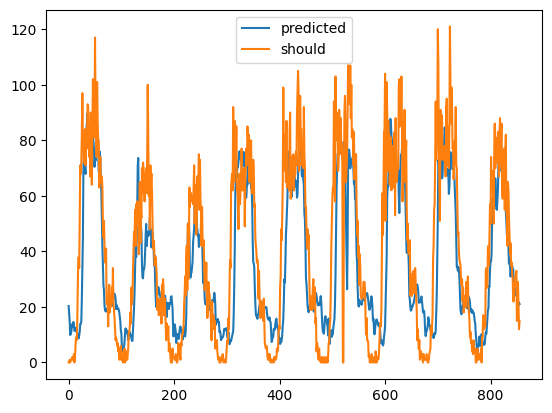

In [53]:
results = model.predict(test_dataset)
print(np.min(results))
#takes labels from the test_dataset
y = np.concatenate([y for x, y in test_dataset], axis=0)
#since each result is an array of each predicted sensor you can input 0 through 9 to look at the graph
plt.plot(results[:, 7], label='predicted')
#if you are wondering why it is like this look at y.shape
plt.plot(y[:,0,7], label='should')
plt.legend()
plt.show()

In [39]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 47ms/step - loss: 21.9996 - accuracy: 0.6776


[21.999605178833008, 0.677570104598999]